# Using the Random Forest Classifier for an imbalanced data set

Date created: Nov 10, 2016   
Last modified: Jan 13, 2017  
Tags: Random Forest, imbalanced data set, semiconductor data   
About: Classify using the Random Forest Classifier. Weight imbalanced semicondutor manufacturing dataset using class_weights. 

<h3>I. Introduction</h3>

The [SECOM dataset](http://archive.ics.uci.edu/ml/datasets/SECOM) in the  [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml) is semicondutor manufacturing data. There are 1567 records, 590 anonymized features and 104 fails. This makes it an imbalanced dataset with a 14:1 ratio of pass to fails. The process yield has a simple pass/fail response (encoded -1/1).

<h4>Objective</h4>
We consider some of the different approaches to classify imbalanced data. In previous exercises we looked at the [one-class SVM](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) and [SVM+oversampling using SMOTE](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_svm_smote.ipynb). In this exercise we consider the Random Forest (RF) classifier.  

The RF classifier is an ensemble method that has been shown to perform very well. A 2014 paper compared 179 classifiers on 121 data sets in the UCI repository and found that the RF was the most accurate classifier overall <a href="#ref1">[1]</a>.  The algorithm has been designed with the assumption that the classes are equally balanced. With imbalanced data, however, the overall error rate and prediction accuracy is skewed to the majority class. To correct for this, two strategies are available for highly imbalanced classes:  
<ol>
<li> cost sensitive learning (penalizing misclassification of the minority class)
<li> resampling to balance the classes
</ol>

We will look at the first of these by reweighting the observations. The two classes will be weighted in inverse proportion to their respective class frequencies so that a heavier penalty is assigned to the misclassification of the minority class. The class weights are incorporated into the RF algorithm in two places. The first is to weight the gini criterion when splitting the data; the second is to weight the majority vote in the terminal nodes which is then aggregated for the final prediction.
 
<h4>Methodology</h4>
There are two parameters in the *sklearn* [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) module to weight the classes. These are `class_weight` and
`sample_weight`. The RF is an ensemble of decision trees, so these options have been derived from the [implementions for the decision tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

We will look at the following:
- Baseline case (where the RF has equal weights)
- Class weights (in inverse proportion to the class frequencies)
- Sample weights (in inverse proportion to the class frequencies)
- Matthews correlation coefficient as a score
- Efficacy of the OOB estimate and CV to select class weights
- ROC curves
- Performance of parsimonious models 


<h4>Preprocessing</h4>
The Random Forest (RF) classifier can handle continuous and categorical varibles and does not require transformations or preprocessing such as one-hot encoding or scaling. The only preprocessing needed is with regards to the missing data.

For this data set, the measurements come from a large number of processes or sensors and many of the records are missing. In addition some measurements are identical/constant and so not useful for prediction. We will remove the columns that have high missing counts or constant values and estimate values for the rest of the missing data. These are the same steps used for the [one-class SVM](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) and a more detailed explanation can be seen there. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split as tts # sklearn 0.18.1
from sklearn.model_selection import GridSearchCV # sklearn 0.18.1

from sklearn.ensemble import RandomForestClassifier
 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, \
classification_report, accuracy_score
from sklearn.metrics import make_scorer, matthews_corrcoef

from time import time
from __future__ import division
import warnings
warnings.filterwarnings("ignore")

In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom = pd.read_table(url, header=None, delim_whitespace=True)

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
y = pd.read_table(url, header=None, usecols=[0], squeeze=True, delim_whitespace=True)

print 'The dataset has {} observations/rows and {} variables/columns.' \
       .format(secom.shape[0], secom.shape[1])
print 'The ratio of majority class to minority class is {}:1.' \
      .format(int(y[y == -1].size/y[y == 1].size))

The dataset has 1567 observations/rows and 590 variables/columns.
The ratio of majority class to minority class is 14:1.


<h3>II. Preprocessing </h3>

We process the missing values first, dropping columns which have a large number of missing values and imputing values for those that have only a few missing values.
The [one-class SVM](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) exercise has a more detailed version of these steps.

In [3]:
# dropping columns which have large number of missing entries 

m = map(lambda x: sum(secom[x].isnull()), xrange(secom.shape[1]))
m_200thresh = filter(lambda i: (m[i] > 200), xrange(secom.shape[1]))
secom_drop_200thresh = secom.dropna(subset=[m_200thresh], axis=1)
dropthese = [x for x in secom_drop_200thresh.columns.values if \
             secom_drop_200thresh[x].std() == 0]
secom_drop_200thresh.drop(dropthese, axis=1, inplace=True)

print 'The SECOM data set now has {} variables.'\
      .format(secom_drop_200thresh.shape[1])

The SECOM data set now has 409 variables.


In [4]:
# imputing missing values for the random forest

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
secom_imp = imp.fit_transform(secom_drop_200thresh)

In [5]:
# split data into train and holdout sets
# stratify the sample used for modeling to preserve the class proportions

X_train, X_test, y_train, y_test = tts(secom_imp, y, \
                                   test_size=0.2, stratify=y, random_state=5)

<h3>III. Random Forest Classification (RFC)</h3>  

We will vary the `class_weight` parameter and evaluate the performance using the [Matthews correlation coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) (<i>MCC</i>). When there is a large skew in the class balance, the overall classification accuracy is not a good performance measure since the True Negatives (the majority class elements correctly classified) dominate the score in these cases. The <i>MCC</i> is an alternative score which uses all four values of the confusion matrix and is therefore considered more balanced.

<h4>1) RFC baseline</h4>

Both the classes are equally weighted with a weight of one. The other parameters, with the exception of the number of trees (<i>n_estimators</i>) and the out-of-bag score (<i>oob_score</i>), are set to default values.

In [6]:
rfc_default = RandomForestClassifier(n_estimators=100, random_state=7,
                                    oob_score=True)
rfc_default.fit(X_train, y_train)
y_pred = rfc_default.predict(X_test)

print 'The confusion matrix: '
cm = confusion_matrix(y_test, y_pred)
print cm
print '\nThe True Positive rate is: {0:4.2f}' \
.format(float(cm[1][1])/np.sum(cm[1]))
print '\nThe Matthews correlation coefficient: {0:3.2f}'\
.format(matthews_corrcoef(y_test, y_pred))
print '\nThe accuracy is: {0:4.2f}' \
.format(accuracy_score(y_test, y_pred))
print '\nThe OOB score: {0:4.2f}' \
.format(rfc_default.oob_score_)

The confusion matrix: 
[[293   0]
 [ 21   0]]

The True Positive rate is: 0.00

The Matthews correlation coefficient: 0.00

The accuracy is: 0.93

The OOB score: 0.93


We can see from the confusion matrix (CM) the True Positive Rate --the accuracy for the minority class -- is zero (see bottom right of the CM). The MCC score, which is 0, reflects this whereas scores such as accuracy (0.93) or the OOB score (0.93) do not.

<h4>2) RFC: assigning class weights</h4>  

We will see how by changing the class weights to the ratio of the class frequencies, the MCC score increases compared to the baseline.    
Applying additional parameters such as the `n_estimators` and `min_samples_split` options along with the `class_weight` can improve the MCC score further. 

Finally, since it has been suggested that the OOB estimate of the accuracy can be used to select the the best `class_weight` parameter <a href="#ref2">[2. See Sec. 2.3]</a>, we will look at the OOB estimate for different `class_weight` inputs.

In [7]:
# function to evaluate the RFC model by varying
# the class weights and some other parameters

def rfc_classweights(class_weight, n_estimators, min_samples_split, verbose):
  
    rfc_cw = RandomForestClassifier(n_estimators=n_estimators, 
                                    class_weight=class_weight,
                                    min_samples_split=min_samples_split,
                                    random_state=7,
                                    oob_score=True)
    rfc_cw.fit(X_train, y_train)
    y_pred = rfc_cw.predict(X_test)
    
    if verbose: # print
        print 'The confusion matrix: '
        cm = confusion_matrix(y_test, y_pred)
        print cm
        print '\nThe True Positive rate is: {0:4.2}' \
        .format(float(cm[1][1])/np.sum(cm[1]))
        print '\nThe Matthews correlation coefficient: {0:4.3f}'\
        .format(matthews_corrcoef(y_test, y_pred))
        print '\nThe OOB score: {0:4.3f}' .format(rfc_cw.oob_score_)
    else:  # don't print, compute  probs instead
        y_prob = rfc_cw.predict_proba(X_test)
        return y_prob       

In [8]:
# changing the class_weight ratio to 0.8/0.2

rfc_classweights({-1:.8, 1:.2}, 100, 3, 1)

The confusion matrix: 
[[291   2]
 [ 20   1]]

The True Positive rate is: 0.048

The Matthews correlation coefficient: 0.105

The OOB score: 0.925


In [9]:
# adjusting class weigths in the proportion of class frequencies

rfc_classweights({-1:.93, 1:.07}, 100, 3, 1)

The confusion matrix: 
[[291   2]
 [ 19   2]]

The True Positive rate is: 0.095

The Matthews correlation coefficient: 0.197

The OOB score: 0.923


In [10]:
# optimizing by selecting n_estimators=500 (number of trees)
# min_samples_split=5 (min samples for splitting node)

rfc_classweights({-1:.93, 1:.07}, 500, 5, 1)

The confusion matrix: 
[[292   1]
 [ 19   2]]

The True Positive rate is: 0.095

The Matthews correlation coefficient: 0.236

The OOB score: 0.925


With the class weight ratio in proportion to the class frequencies (0.93 and 0.07), the MCC changes from the baseline 0 to 0.197. The score further improves to 0.236 when the parameters are set to `n_estimators`=500 and `min_samples_split`=5.

In all these cases (the baseline, the `class_weight` at  0.8/0.2 and 0.93/0.07), the OOB score --which calculates generalization accuracy-- remains unchanged around 0.92. Since the OOB estimate only reflects the accuracy, we will not use it to select the optimal class weighting.

<h4>3) RFC: assigning sample weights</h4>  

The `sample_weight` which is an option provided with the `fit` method is another way to weight the classes. It has the same effect as the class weight so we should expect similar results. As explained [here](http://stackoverflow.com/a/34661470), the two options allow the weighting routine to be accessed in different ways. 

In [11]:
# the sample weight uses a 1D-array of weights as input
sample_weight = np.array([14 if i == -1 else 1 for i in y_train])

rfc_sw = RandomForestClassifier(n_estimators=100, random_state=7, 
                                min_samples_split=3, oob_score=True)
rfc_sw.fit(X_train, y_train, sample_weight)
y_pred = rfc_sw.predict(X_test)

print 'The confusion matrix: '
cm = confusion_matrix(y_test, y_pred)
print cm
print '\nThe Matthews correlation coefficient: {0:4.3f}'\
.format(matthews_corrcoef(y_test, y_pred))
print '\nThe OOB score: {0:4.3f}'.format(rfc_sw.oob_score_)

The confusion matrix: 
[[291   2]
 [ 19   2]]

The Matthews correlation coefficient: 0.197

The OOB score: 0.924


When the weights assigned are in proportion to the class frequencies (and `n_estimators`=100, `min_samples_split`=3), both the `sample_weight` and `class_weight` options give similar results. The MCC score is 0.197 in both cases.

<h4>4) Hyperparameter selection via cross-validation</h4>

The usual way to select parameters is via grid-search and cross-validation (CV). The default CV scoring is based on the accuracy so we will replace this with an MCC scorer. 

In [7]:
# defining the MCC metric to assess cross-validation

def mcc_score(y_true, y_pred):
    mcc = matthews_corrcoef(y_true, y_pred)
    return mcc
    
mcc_scorer = make_scorer(mcc_score, greater_is_better=True)

In [13]:
# cross-validation

#n_estimators = 500 gives better results 
clf = RandomForestClassifier(n_estimators=500, random_state=7, n_jobs=-1)

param_grid = {"max_depth": [3, 8, None],
              "class_weight": [{-1:.90, 1:.10}, {-1:.93, 1:.07}, {-1:.99, 1:.01}],
              "min_samples_split": [2, 3, 5],
              "max_features": ["sqrt", "log2", "auto", None],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid,  scoring=mcc_scorer)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
     % (time() - start, len(grid_search.grid_scores_)))


GridSearchCV took 9297.66 seconds for 216 candidate parameter settings.


In [14]:
print 'The best parameters:'
print '{}\n'. format(grid_search.best_params_)

print 'Results for model fitted with the best parameter:'
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

print 'The confusion matrix: '
cm = confusion_matrix(y_true, y_pred)
print cm

print '\nThe True Positive rate is: {0:4.2}'\
.format(float(cm[1][1])/np.sum(cm[1]))

print '\nThe Matthews correlation coefficient: {0:4.3f}'\
.format(matthews_corrcoef(y_test, y_pred))

The best parameters:
{'max_features': 'sqrt', 'min_samples_split': 5, 'criterion': 'gini', 'max_depth': None, 'class_weight': {1: 0.01, -1: 0.99}}

Results for model fitted with the best parameter:
             precision    recall  f1-score   support

         -1       0.94      1.00      0.97       293
          1       0.67      0.10      0.17        21

avg / total       0.92      0.94      0.91       314

The confusion matrix: 
[[292   1]
 [ 19   2]]

The True Positive rate is: 0.095

The Matthews correlation coefficient: 0.236


The CV was based on the MCC score and the MCC for the best model is 0.236. Some of the parameters (`max_features`= sqrt, `criterion` = gini, `max_depth` = None) for the best model are default options. The `class_weight` is 0.99/.01 and `min_samples_split` is 5. The number of trees was set at 500 because we saw this gave the best_results in Section III (3) above.    
A model we ran (Section III (3)) with the same parameters and a `class_weight` of .93/.07 also had an MCC of 0.236 and this appears to be the best we can do with the RF classifier.

<h4>5) ROC curves</h4>

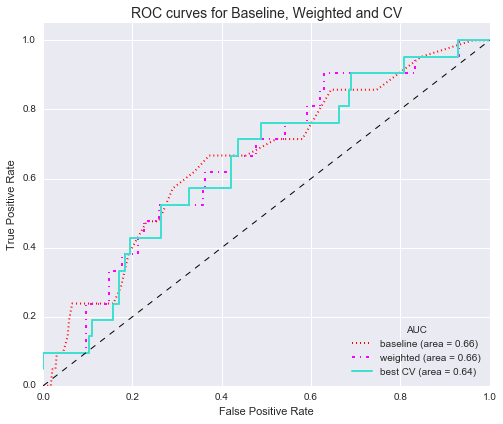

In [15]:
#plot for baseline
y_prob = rfc_default.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6.5))
plt.plot(fpr, tpr, color='red', lw=2, linestyle=':',
                 label='baseline (area = {0:0.2f})'
                 ''.format(roc_auc))

# plot for weighted classes
# class_weights .93/.07, n_estimators=500, min_samples_split=5
y_prob = rfc_classweights({-1:.93, 1:.07}, 500, 5, 0)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='magenta', lw=2, linestyle='-.',
                 label='weighted (area = {0:0.2f})'
                 ''.format(roc_auc))


# plot for optimal CV hyperparameters
y_prob = grid_search.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='turquoise', lw=2, linestyle='-',
                 label='best CV (area = {0:0.2f})'
                 ''.format(roc_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for Baseline, Weighted and CV', fontsize=14)
plt.legend(title='AUC', loc="lower right")

plt.show()

The AUC values are the same for the baseline, the weighted and the optimal model via cross-validation. [To complete later]

<h4>6) A more parsimonious model</h4>

In the experiments above, after preprocessing for the missing data, all the 409 features available were used. The RF variable importance can rank features in order of importance and in the [One-class SVM](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) exercise, we saw that some of the RF features had a variable importance score of zero. In this section, we will compute the MCC for RF models where for each subsequent model, the number of features (included in order of rank) is incremented. 

In [8]:
# we use a DataFrame to acess ranked columns
X_train = pd.DataFrame(X_train) 
X_test = pd.DataFrame(X_test)

# the RF model is weighted
rfc_p1 = RandomForestClassifier(n_estimators=500, 
                                class_weight={-1:.93, 1:.07},
                                min_samples_split=5,
                                random_state=7)
rfc_p1.fit(X_train, y_train)

importance = rfc_p1.feature_importances_
ranked_indices = np.argsort(importance)[::-1]

# print out the features, their rank 
print "Feature Rank:"
for i in range(8):
    print "{0:3d} column {1:3d}  {2:6.4f}"\
    .format(i+1, ranked_indices[i], importance[ranked_indices[i]])
print "\n"
for i in xrange(len(importance)-3,len(importance)):
    print "{0:3d} column  {1:3d}  {2:6.4f}"\
    .format(i+1, ranked_indices[i], importance[ranked_indices[i]])

Feature Rank:
  1 column  55  0.0176
  2 column 176  0.0135
  3 column 131  0.0122
  4 column  61  0.0119
  5 column  90  0.0113
  6 column  85  0.0112
  7 column 311  0.0108
  8 column 325  0.0104


407 column  172  0.0000
408 column   62  0.0000
409 column  352  0.0000


In [12]:
# Compute MCC for different RF models. 
# The number of ranked features is increased for each subsequent model

mcc_scores = []
nfeatures = np.arange(40, 401, 20) # no. of features used
rfc_p2 = RandomForestClassifier(n_estimators=500, 
                                class_weight={-1:.93, 1:.07},
                                min_samples_split=5, random_state=7)

for i in nfeatures:
   rfc_p2.fit(X_train[ranked_indices[:i]], y_train)
   y_pred = rfc_p2.predict(X_test[ranked_indices[:i]])

   mcc_scores = np.append(mcc_scores, matthews_corrcoef(y_test, y_pred))

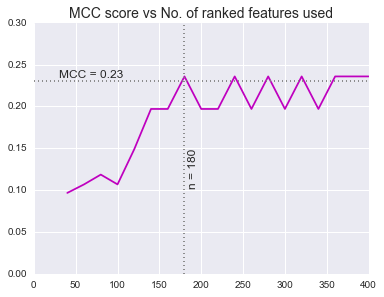

In [18]:
# plot the MCC scores 

plt.figure(figsize=(6,4.5))
plt.plot(nfeatures, mcc_scores, 'm')
plt.axvline(180, color='gray', linestyle='dotted')
plt.text(184, 0.14, 'n = 180', rotation='vertical', fontsize=12)
plt.axhline(y=.23, color='gray', linestyle='dotted')
plt.text(30, 0.235, 'MCC = 0.23', fontsize=12)
#plt.xlabel('No of ranked features')
#plt.ylabel('MCC')
plt.ylim([0.0, 0.30])
plt.title('MCC score vs No. of ranked features used', fontsize=14)
plt.show()

From the plot we see that the MCC score of 0.236 stabilizes after n = 180 (<i>n</i> is the number of features used). The variation we see beyond that can be attributed to the inherent variability in the RF runs. One of the characteristics of the random forest algorithm is that it performs well even with a large number of features and we see that using a larger number of variables does not impair the RF performance in our experiments either.

<h3>IV. Summary</h3>

Here we were interested in the performance improvements we would get with a weighted Random Forest applied to a heavily skewed data set. The Matthews correlation coefficient was 0.236 for the best models.

In a previous exercise we had experimented with [SVM+oversampling using SMOTE](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_svm_smote.ipynb) and we had obtained similar performance for the MCC but the AUC score were marginally better. The SVM combined with a sampling strategy holds promise and we  will next look at a combination of oversampling (the minority class) and undersampling (the majority class).

<h3>V. References and Further Reading </h3>

<a name="ref1"></a>[1] [Fernández-Delgado, Manuel, et al. "Do we need hundreds of classifiers to solve real world classification problems." J. Mach. Learn. Res 15.1 (2014): 3133-3181.](http://www.jmlr.org/papers/volume15/delgado14a/delgado14a.pdf)

<a name="ref2"></a>[2] [Chao Chen, Andy Liaw, Leo Breiman. "Using Random Forest to Learn Imbalanced Data." Report ID 666. Retrieved from Univ. of California Berkeley Mathematics Statistics Library. (2004)](http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/666.pdf)


<div style="background-color: #FAAC58; margin-left: 0px; margin-right: 20px; padding-bottom: 8px; padding-left: 8px; padding-right: 8px; padding-top: 8px;">


Author:  Meena Mani  <br>
email:   meenas.mailbag@gmail.com   <br> 
twitter: @meena_uvaca    <br>
</div>